<a href="https://colab.research.google.com/github/valerijakeda/valerijakeda/blob/main/Python_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RFM Segmentation Code**

**First Step:** importing libraries we will need for this analysis

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from statistics import mean 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Second Step:** creating segment dictionary

In [210]:
def creating_segments():
  """Function that assigns segmenting keys to a dictionary
  """
  seg_map = {}
  for key in ['311', '312', '313', '314', '411', '412', '413', '414']:
    seg_map[key] =  'New Customers'
  for key in ['111', '112']:
    seg_map[key] = 'Lost'
  for key in ['114', '113', '123', '124', '133', '134', '144', '143', '213', '214', '223', '224', '233', '234', '243', '244']:
    seg_map[key] = 'Can\'t Lose'
  for key in ['121', '122', '131', '132', '141', '142', '211', '212', '221', '222', '231', '232', '241', '242']:
    seg_map[key] = 'Need Attention'
  for key in ['321', '322','331', '332','341','342', '421', '422', '431', '432', '441', '442']:
    seg_map[key] = 'Good Customers'
  for key in ['323', '324', '423', '424']:
    seg_map[key] = 'Potential Loyalists'
  for key in ['333', '334', '343', '433', '434', '443', '344']:
    seg_map[key] = 'Loyal Customers'
  seg_map['444'] = 'Champions'
  return seg_map

In [211]:
seg_map = creating_segments() 

**Third Step:** importing the dataframe we need from BigQuery
Note: authentication from the account you use for BigQuery is required to access the database

In [212]:
def import_dataframe_bigquery (database_name, data_frame_index, project_id = 'tc-da-1'):
  """Function that imports a dataframe from a given database in BigQuery
  The default project_id is 'tc-da-1'
  Note: It is neccesary to give an access to your google account connected to BigQuery, where your projects are
  """
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')
  
  from google.cloud import bigquery
  client = bigquery.Client(project = project_id)
  dataset_ref = client.dataset(database_name, project = project_id)
  dataset = client.get_dataset(dataset_ref)
  tables = list(client.list_tables(dataset))
  print("Database Was Succesfully Imported")

  df = client.list_rows(tables[data_frame_index]).to_dataframe()
  
  return df

Third Step: importing dataframe we need from Google Sheets Note: authentication from your account is required to access files

In [213]:
def import_data_sheets (file_name):
  """Function that imports a dataframe from a given Google Sheets sheet from the account that is connected
  """
  from google.colab import auth
  auth.authenticate_user()

  import gspread
  from google.auth import default
  creds, _ = default()

  gc = gspread.authorize(creds)

  worksheet = gc.open('Data').sheet1

  # get_all_values gives a list of rows.
  rows = worksheet.get_all_values()

  # Convert to a DataFrame and render.
  df = pd.DataFrame.from_records(rows)
  
  df = df.rename(columns=df.iloc[0]) 

  # drop first row
  df.drop(index=df.index[0], axis=0, inplace=True) 
  return df

In [214]:
#df = import_dataframe_bigquery('turing_data_analytics', 2) #I need rfm table which is third from the beggining
df = import_data_sheets('Data')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,544612,22053,EMPIRE DESIGN ROSETTE,3906,02-22-11,0.82,18087,United Kingdom
2,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,07-19-11,0.06,14609,United Kingdom
3,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,01-11-2011,2.1,15749,United Kingdom
4,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,04-18-11,2.1,15749,United Kingdom
5,560040,23343,came coded as 20713,3100,07-14-11,0,,United Kingdom


**Fourth Step:** cleaning and preparing data from dataframe for the analysis

In [215]:
def cleaning_for_rfm (df, date_column, quantity_column, unit_price_column, stock_code_column):
  """This cleaning function is designed for dataframes with particular types of columns like: 'InvoiceDate', 'UnitPrice' and 'Quantity' are necessary
  """
  df = df.drop_duplicates()
  df.isnull().sum()
  df.dropna(inplace=True)
  try: 
    df[date_column] = pd.to_datetime(df[date_column])
    df[unit_price_column] = pd.to_numeric(df[unit_price_column])
    df[quantity_column] = pd.to_numeric(df[quantity_column])
    df['Total_Price'] = df[unit_price_column]*df[quantity_column]
  except: 
    print('DataFrame doesn\'t have necessary columns for this analysis')
    exit()
  try: 
    df = df[~df[stock_code_column].str.contains('B')]
  except: 
    pass
  return df

In [216]:
df = cleaning_for_rfm(df, 'InvoiceDate', 'Quantity', 'UnitPrice', 'StockCode')

**Fifth Step:** assigning values to a new RFM dataframe 

In [217]:
def assigning_values(df, seg_map, customerid_column, invoice_date_column, invoice_no_column):
  """RFM analysis function (scalling from 1 to 4). 
  Note: Before using it - create a segmentation map using function creating_segments() or use your custom one but with scalling from 1 to 4 and all 3 values
  """
  rfm = df.groupby(customerid_column).agg({invoice_date_column : lambda day : (df[invoice_date_column].max() - day.max()).days, invoice_no_column: lambda num : len(num), 'Total_Price': lambda price : price.sum()})
  column_list = ['Recency','Frequency','Monetary']
  rfm.columns = column_list
  rfm["R"] = pd.qcut(rfm["Recency"],4 ,labels = [4,3,2,1])
  rfm["F"] = pd.qcut(rfm["Frequency"],4 ,labels = [1,2,3,4])
  rfm["M"] = pd.qcut(rfm["Monetary"],4 ,labels = [1,2,3,4])
  rfm["RFM"] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm["M"].astype(str)
  rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm["M"].astype(str)
  rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)

  return rfm

In [218]:
def show_rfm_full_list(rfm):
  with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(rfm)

In [219]:
rfm = assigning_values(df, seg_map, 'CustomerID', 'InvoiceDate', 'InvoiceNo')

**Sixth Step:** plotting RFM bubble chart grouped by RFM Segments

In [220]:
def plotting_rfm(rfm):
  """Function that is plotting a bubble chart for RFM analysis using Seaborn Package
  """
  fig = plt.figure(figsize = (14, 8))
  bubble_chart = sns.scatterplot(data = rfm.groupby('Segment').mean(), x = "Recency", y = "Frequency", size = "Monetary", hue = "Segment", legend = True, sizes=(20, 2000))
  bubble_chart.set(title = 'RFM Segmentation')
  plt.legend(fontsize='medium', title_fontsize='10')
  plt.show()

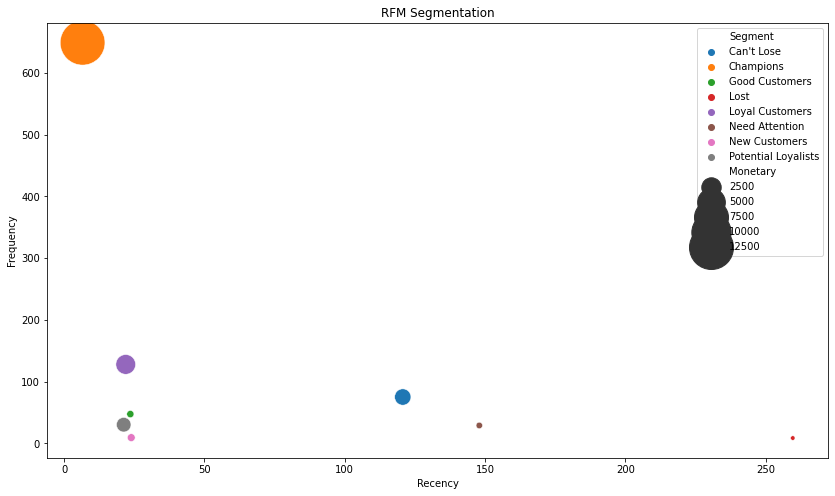

In [221]:
plotting_rfm(rfm)

**Additional Step:** plotting a bar chart showing the number of invoices by Category and for given range

In [222]:
def plotting_bar_chart(df, invoice_no_column, category, r_number1, r_number2):
  """Function that is plotting a bar chart based on category for given range (default category - Country) using Seaborn Package
  """
  invoices = dict()
  for number in df[invoice_no_column]:
      invoices[number] = invoices.get(number, 0) + 1

  df_invoices = pd.DataFrame(invoices.items(), columns=[invoice_no_column, 'Number'])

  df_with_category = pd.merge(df_invoices,df[[invoice_no_column,category]], on = invoice_no_column, how = 'inner')

  fig = plt.figure(figsize = (8, 8))
  bar_chart = sns.countplot(data = df_with_category, x = category, order = df_with_category[category].value_counts().index[r_number1:r_number2])
  bar_chart.set(title = 'Orders amount based on ' + category)
  #to add values to the bars
  for p in bar_chart.patches:
    bar_chart.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
  plt.show()

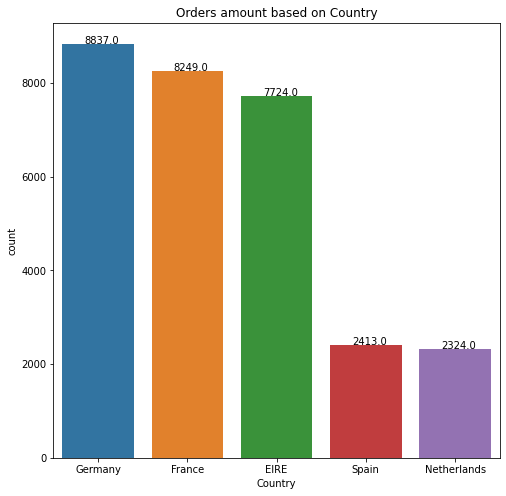

In [223]:
plotting_bar_chart(df,'InvoiceNo','Country', 1, 6)

**Additional Step:** plotting a pie chart compating numbers of orders and returns

In [224]:
def plotting_pie_chart(df, invoice_no_column, difference, labels):
  """This function fits if you have 2 different categories
  Note: the difference in InvoiceNo must be in the begining of the name
  """
  variables = [0, 0]
  for name in df[invoice_no_column]:
    if name.startswith(difference):
      variables[0] = variables[0] + 1
    else:
      variables[1] = variables[1] + 1
  
  plt.pie(variables, labels = labels, autopct='%.0f%%')
  plt.title("PieChart : Invoices from United Kingdom comparing to Other Countries")
  plt.show()

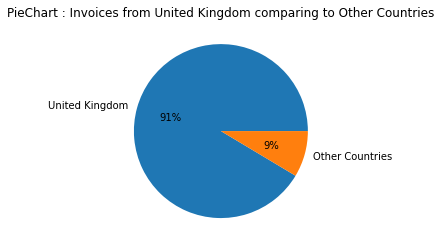

In [225]:
plotting_pie_chart(df, 'Country','United Kingdom', ['United Kingdom', 'Other Countries'])